In [94]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage
from scipy.misc import imsave
%matplotlib inline

In [95]:
def noiseReductionUsingGaussian(image, Kx = 5, Ky = 5) :
    """
    Performs Gaussian Blurring
    
    Parameters
    ----------
    image : (M,N) ndarray
        Input image
    Kx : Int
        Kernel size in X direction
    Ky : Int
        Kernel size in Y direction
   
    Returns
    -------
    image : (M, N) ndarray
        Image after smoothing.
    """
    blur = cv2.GaussianBlur(image,(Kx,Ky),0)
    return blur

(870, 1160)


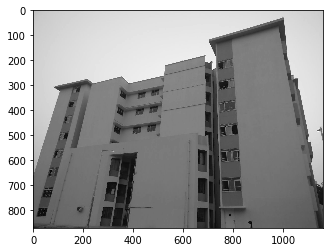

In [119]:
image = cv2.imread("/home/guru/Desktop/ComputerVision/Assignment1/IpythonNotebooks/Building2.jpeg",0)
print(image.shape)
plt.imshow(image,cmap = "gray")

In [120]:
image

array([[189, 189, 189, ..., 202, 202, 202],
       [189, 189, 189, ..., 202, 202, 202],
       [189, 189, 189, ..., 202, 202, 202],
       ..., 
       [ 39,  40,  40, ...,  38,  39,  39],
       [ 34,  35,  34, ...,  38,  38,  38],
       [ 43,  42,  41, ...,  37,  38,  38]], dtype=uint8)

In [121]:
#Noise Removal Step
blur = noiseReductionUsingGaussian(image,3,3)

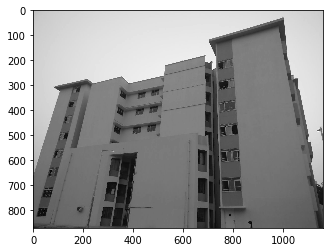

In [122]:
plt.imshow(image,cmap = "gray")

In [123]:
def round_angle(angle) :
    """
    Converts angle in radians to degrees and rounds off to nearest direction angle
    
    Parameters 
    ----------
    angle : Radians
        Angle to be converted
    
    Returns
    --------
    angle : Degrees
        One of the direction angle
    
    """
    #Converting angle from radians to degrees
    angle = np.rad2deg(angle) % 180
   # print(angle)
    
    #Rounding to horizontal direction
    if (0 <= angle < 22.5) or (157.5 <= angle < 180):
        angle = 0
        
    #Rounding to diagonal direction
    elif(22.5 <= angle < 67.5):
        angle = 45
        
    #Rounding to vertical direction
    elif(67.5 <= angle < 112.5):
        angle = 90
    
    #Rounding to diagonal direction
    else :
        angle = 135
        
    return angle

In [124]:
def intensity_gradient(image, Kx = 3, Ky = 3) :
    """
    Calculates the gradient and its direction for entire image using Sobel Operator
    
    Parameters
    ----------
    image : (M,N) ndarray
        Input image
    Kx : Int
        Kernel size in X direction
    Ky : Int
        Kernel size in Y direction
    
    Returns
    -------
    (Gradient, Direction, Ix, Iy) : Tuple
    
    """
    #Finding Gradient using sobel operator  
    #Applying Kernels to the image
    Ix = cv2.Sobel(image,cv2.CV_64F,1,0,ksize=Kx)
    Iy = cv2.Sobel(image,cv2.CV_64F,0,1,ksize=Ky)
    

    #Calculating the gradient magnitude and direction
    G = np.hypot(Ix, Iy)
    D = np.arctan2(Iy, Ix);
    
    #Calculating the Directions by rounding off
    M, N = D.shape
    R_D = np.zeros((M,N), dtype = np.int32)
    
    #print(D.shape)
    #print(D[0][0])
    for i in range(M) :
        for j in range(N) :
            R_D[i][j] = round_angle(D[i,j])
    
    return (G,R_D,Ix,Iy)

In [125]:
gradient, direction,Ix,Iy = intensity_gradient(blur)

In [126]:
np.min(Ix)

-482.0

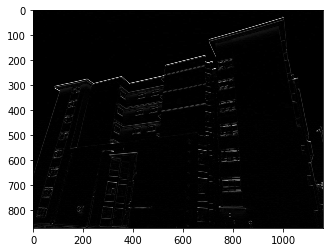

In [127]:
plt.imshow(np.abs(Iy),cmap = "gray")

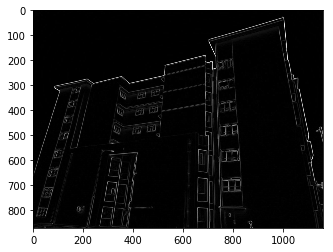

In [128]:
plt.imshow(gradient,cmap = "gray")

In [129]:
direction

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,  45, ...,   0,   0,   0],
       [  0,  45,  45, ...,   0,   0,   0],
       ..., 
       [ 90,  90,  90, ..., 135, 135,  90],
       [ 90,  90,  90, ..., 135, 135,  90],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=int32)

In [130]:
def non_max_supression(gradient, direction) :
    """
    Performs Non max Supression which removes any unwanted pixels which may not constitute the edge 
    
    Parameters
    -----------
    gradient : [M,N] ndarray
        Contains the gradient magnitude at each and every pixel co-ordinate
    direction : [M,N] ndarray
        Contains the direction information of the gradient
        
    Returns
    -------
    S : [M,N] array
    gradient array but this has pixels which constitute the edge, others will be marked as O
    
    """
    M, N = gradient.shape
    S = np.zeros((M,N), dtype = np.int32)
    #Todo : Dealing in a better way with boundary points
    for i in range(M):
        for j in range(N):
            if(direction[i][j] == 0) :
                if((j!= 0 and j!= N-1) and (gradient[i, j] >= gradient[i, j - 1]) and (gradient[i, j] >= gradient[i, j + 1])):
                    S[i,j] = gradient[i,j]
                    
            elif(direction[i][j] == 90) :
                if ((i!=0 and i!= M-1) and (gradient[i, j] >= gradient[i - 1, j]) and (gradient[i, j] >= gradient[i + 1, j])):
                    S[i,j] = gradient[i,j]
            
            elif(direction[i][j] == 135) :
                if ((i!=0 and i!=M-1 and j!=0 and j!= N-1 ) and (gradient[i, j] >= gradient[i - 1, j + 1]) and (gradient[i, j] >= gradient[i + 1, j - 1])):
                    S[i,j] = gradient[i,j]
            
            elif(direction[i][j] == 45) :
                if ((i!=0 and i!=M-1 and j!=0 and j!= N-1 ) and gradient[i, j] >= gradient[i - 1, j - 1]) and (gradient[i, j] >= gradient[i + 1, j + 1]):
                    S[i,j] = gradient[i,j]
    
    return S
    

In [131]:
S = non_max_supression(gradient, direction)

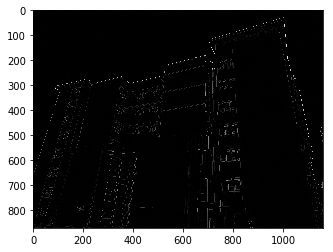

In [132]:
plt.imshow(S, cmap = "gray")

In [133]:
S

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  4, ...,  0,  0,  0],
       ..., 
       [48, 50, 55, ...,  0,  0,  4],
       [ 0,  0,  0, ...,  0,  0,  4],
       [ 0,  0,  8, ...,  0,  0,  0]], dtype=int32)

In [134]:
def hysteresisThresholding(image, low, high) :
    """
    This function decides which are all edges are really edges and which are not by means of thresholding
    based on two values
    
    Parameters
    -----------
    image : (M, N) ndarray
        Input image 
    low : Int
        Minimum value of threshold
    high : Int
        Maximum value of threshold
    
    Returns
    --------
    thresholded : (M,N) boolean ndarray 
        Binary edges with edges marked as true
    """
    low = np.clip(low, a_min=None, a_max=high)  # ensure low always below high
    mask_low = image > low
    mask_high = image > high
    # print(mask_high*1)
    # Connected components of mask_low
    labels_low, num_labels = ndimage.label(mask_low)

    # Check which connected components contain pixels from mask_high
    sums = ndimage.sum(mask_high, labels_low, np.arange(num_labels + 1))
    connected_to_high = sums > 0
    thresholded = connected_to_high[labels_low]
    return thresholded


In [135]:
S

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  4, ...,  0,  0,  0],
       ..., 
       [48, 50, 55, ...,  0,  0,  4],
       [ 0,  0,  0, ...,  0,  0,  4],
       [ 0,  0,  8, ...,  0,  0,  0]], dtype=int32)

In [136]:
blah = hysteresisThresholding(S,50,100)

In [137]:
blah.dtype

dtype('bool')

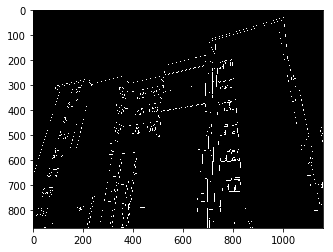

In [138]:
plt.imshow(blah, cmap = "gray")

In [116]:
def hsvColor(edgeImage, gradient, direction) :
    """
    Assigns colors the edges based on the direction and the intensity value of 
    the color depends on the magnitude of the gradient at the point
    
    Parameters
    -----------
    edgeImage : [M, N] ndarray
        Binary Image with edges assigned value of 255
    gradient : [M,N] ndarray
        Contains the gradient magnitude at each and every pixel co-ordinate
    direction : [M,N] ndarray
        Contains the direction information of the gradient
        
    Returns
    --------
    hsvColoredImage : [M, N] ndarray
        Image colored based on the gradient direction and magnitude
        
    """
    M,N = edgeImage.shape
    hsv_image = np.zeros((M,N,3), dtype = np.uint8) 
    max_gradient = np.max(gradient)
    min_gradient = np.min(gradient)
    for i in range(M) :
        for j in range (N) :
            if(edgeImage[i][j]) :
                v = int(255*((gradient[i][j] - min_gradient)/(max_gradient - min_gradient)))
                if(direction[i][j] == 0) :
                    hsv_image[i][j] = [0,255,v]
                elif(direction[i][j] == 45) :
                     hsv_image[i][j] = [45,255,v]
                elif(direction[i][j] == 90) :
                     hsv_image[i][j] = [90,255,v]
                else :
                     hsv_image[i][j] = [135,255,v]
                        
    return cv2.cvtColor(hsv_image,cv2.COLOR_HSV2RGB)

In [117]:
hsv_image = hsvColor(blah, gradient, direction)

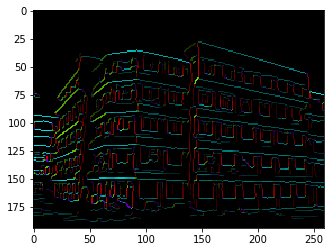

In [118]:
plt.imshow(hsv_image)

In [93]:
imsave("hsv_image.png", hsv_image)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  """Entry point for launching an IPython kernel.
